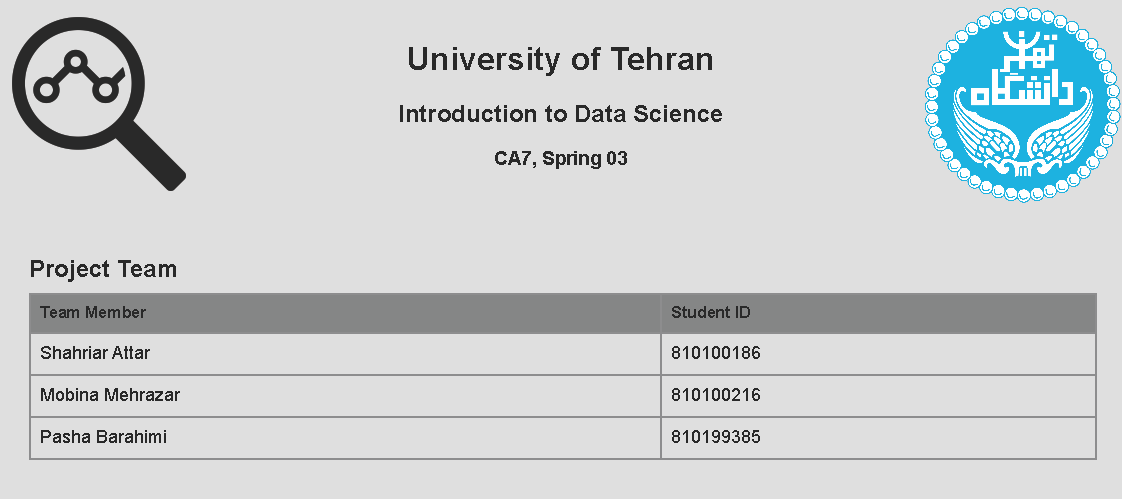

# Semi Supervised Learning and LLMs

## Table of Contents

- [Introduction](#introduction)
- [Objectives](#objectives)
- [Tasks](#tasks)
- [Dataset Description](#dataset-description)
- [Environment Setup](#environment-setup)
- [EDA](#eda)
- [Feature Engineering](#feature-engineering)
- [Semi Supervised](#semi-supervised)
  - [Traditional Methods (Label Propagation)](#traditional-methods-label-propagation)
  - [LLMs](#llms)
  - [Evaluation](#evaluation)
- [Questions](#questions)
- [References](#references)

## Introduction

We have been employed at Amazon as a data scientist for its movie analysis department. In this assignment, we are given a dataset and asked to train a model to classify IMDb review comments automatically. First, we need to use different methods to expand our labeled data for training, extract features from sentences, and then train and evaluate our model.

## Objectives

This assignment aims to:

- Implementing traditional semi-supervised learning methods.
- Using LLMs to classify IMDb review comments.

## Tasks

- Perform EDA on the Dataset
- Feature Engineering
- Label Propagation
- Using LLMs for Semi-Supervised Learning

## Dataset Description

In real-world scenarios, the majority of data remains unlabeled, and labeling all of it can be prohibitively expensive. Instead, we label a portion of the data and attempt to extend these labels to other samples, constituting a semi-supervised task.

We are given a dataset containing information about movies and their user reviews on Amazon's movie platform.

The dataset comprises movie reviews submitted by users on IMDb for sentiment analysis tasks. Sentiment in movie comments refers to the overall emotional tone or attitude expressed towards a movie in a comment or review, which could be positive or negative. Positive sentiment might indicate enjoyment, appreciation, or excitement about the movie, while negative sentiment could suggest disappointment, dislike, or criticism.

This dataset is provided in a structured JSONL format. Each entry usually contains:

- The text of a review.
- Its corresponding sentiment label (1 for positive, 0 for negative).
- A feature vector (embedding) for each comment, which is used to train machine-learning models.

The dataset segments are as follows:

- Training dataset: We'll use this portion of the data to train our models.
- Test dataset: We'll use this portion of the data for validation.
- Augmentation dataset: This unlabeled portion of the data should be labeled using existing models (machine learning models or large language models) to augment our training dataset.

## Environment Setup

Let's begin with setting up the Python environment and importing the necessary libraries.

In [ ]:
%pip install -U transformers
%pip install -U accelerate

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
import torch

from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud

from collections import Counter
from PIL import Image

from transformers import AutoTokenizer, AutoModelForCausalLM

In [2]:
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)

True

In [3]:
MODEL_ARGS = {
    "Name": "microsoft/Phi-3-mini-128k-instruct",
    "DType": torch.bfloat16,
}

TRAIN_DATASET_PATH = "../data/train_imdb.jsonl"
TEST_DATASET_PATH = "../data/test_imdb.jsonl"
AUGMENTATION_DATASET_PATH = "../data/aug_imdb_unlabeled.jsonl"

IMDB_LOGO_PATH = "../assets/imdb.png"

In [4]:
def load_model(model_args: dict) -> tuple:
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = AutoModelForCausalLM.from_pretrained(
        model_args["Name"],
        trust_remote_code=True,
        torch_dtype=model_args["DType"],
        low_cpu_mem_usage=True,
        device_map={"": device},
    )
    tokenizer = AutoTokenizer.from_pretrained(
        model_args["Name"],
        trust_remote_code=True,
    )

    return model, tokenizer

In [5]:
df_train = pd.read_json(TRAIN_DATASET_PATH, lines=True)
df_test = pd.read_json(TEST_DATASET_PATH, lines=True)
df_aug = pd.read_json(AUGMENTATION_DATASET_PATH, lines=True)

## EDA

Before we start building models, we need to take a close look at the data. This means examining information about movies and user reviews on Amazon. We want to understand what people are saying about the movies and what features they talk about the most. This helps us decide how to work with the data to build accurate models later on. We should also research how we can do EDA, on text data.

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       150 non-null    object
 1   label      150 non-null    int64 
 2   embedding  150 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.6+ KB


In [7]:
df_train.head()

,text,label,embedding
0,fairly good romantic comedy in which i don't t...,1,"[-0.0167805497, -0.0395836979, 0.1233159453000..."
1,"""dressed to kill"", is one of the best thriller...",1,"[-0.12526972590000002, 0.10147688540000001, 0...."
2,i'm glad that users (as of this date) who like...,1,"[0.1312361956, 0.0294876788, 0.2328549027, -0...."
3,needed an excuse to get out of the house while...,0,"[0.1387384981, 0.0460377187, 0.3447172046, -0...."
4,john candy's performance in once upon a crime ...,1,"[0.1606466323, -0.1768193543, 0.35633808370000..."


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       150 non-null    object
 1   label      150 non-null    int64 
 2   embedding  150 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.6+ KB


In [9]:
df_test.head()

,text,label,embedding
0,the 60s (1999) d: mark piznarski. josh hamilto...,0,"[-0.2179879397, -0.1741176099, 0.0884851664000..."
1,hello. this movie is.......well.......okay. ju...,1,"[-0.07834710930000001, -0.279764235, 0.6189775..."
2,eyeliner was worn nearly 6000 years ago in egy...,1,"[0.03139963, -0.1652034372, 0.1265712678, -0.0..."
3,"this has to be, by far, the absolute worst mov...",0,"[-0.0552324504, -0.1593759954, 0.0467776954, -..."
4,"i like silent films, but this was a little too...",0,"[0.0934860557, 0.026243483600000003, 0.0843501..."


In [10]:
df_aug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       1014 non-null   object
 1   embedding  1014 non-null   object
dtypes: object(2)
memory usage: 16.0+ KB


In [11]:
df_aug.head()

,text,embedding
0,there is no relation at all between fortier an...,"[-0.09757755700000001, -0.1536363065, 0.311417..."
1,in the process of trying to establish the audi...,"[-0.00033669360000000004, 0.08777780830000001,..."
2,i give this movie 7 out of 10 because the vill...,"[-0.275570631, -0.32913637160000003, 0.0793179..."
3,this is the best sci-fi that i have seen in my...,"[0.1461943835, -0.2785910368, 0.4456491172, -0..."
4,what an appalling piece of rubbish!!! who are ...,"[0.1696606129, 0.354041934, 0.4451519549000000..."


First, we should remove the HTML tags from the text data.

In [12]:
def check_html_tags(df: pd.DataFrame) -> set:
    html_tags = set()
    for i in range(len(df)):
        html_tags.update(re.findall(r"<[^>]+>", df.iloc[i]["text"]))
    return html_tags

html_tags_train = check_html_tags(df_train)
html_tags_test = check_html_tags(df_test)
html_tags_aug = check_html_tags(df_aug)

In [13]:
html_tags_train

{'<br />'}

In [14]:
html_tags_test

{'<br />'}

In [15]:
html_tags_aug

{'<br />'}

In [16]:
def remove_html_tags(text: str) -> str:
    return re.sub(r"<[^>]+>", "", text)

df_train["text"] = df_train["text"].apply(remove_html_tags)
df_test["text"] = df_test["text"].apply(remove_html_tags)
df_aug["text"] = df_aug["text"].apply(remove_html_tags)

Now, let's check the distribution of the sentiment labels in the training dataset.

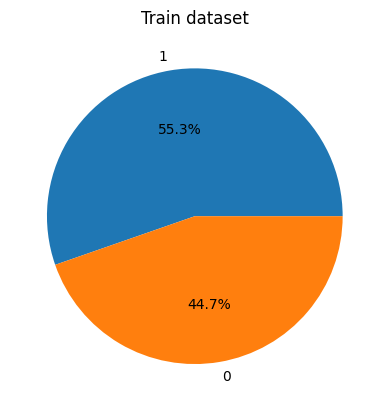

In [17]:
plt.pie(df_train.value_counts("label"), labels=df_train["label"].unique().tolist(), autopct='%1.1f%%')
plt.title("Train dataset")
plt.show()

As we can see, 55.3% of the reviews are positive, while 44.7% are negative. This is a balanced dataset, which is good for training machine learning models.

We can find the following features in the dataset:

- Length of the review.
- Number of words in the review.
- Average word length in the review.
- Average sentence length in the review.

Let's calculate these features and visualize them.

In [18]:
def plot_feature(df: pd.DataFrame, feature: str) -> None:
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[feature], hue=df["label"])
    plt.title("Boxplot")
    plt.subplot(1, 2, 2)
    sns.kdeplot(x=df[feature], hue=df["label"])
    plt.title("KDE plot")
    plt.legend(df["label"].unique().tolist())
    plt.show()

In [19]:
def with_length(df: pd.DataFrame) -> pd.DataFrame:
    df["length"] = df["text"].str.len()
    return df

In [20]:
df_train = with_length(df_train)
df_test = with_length(df_test)
df_aug = with_length(df_aug)

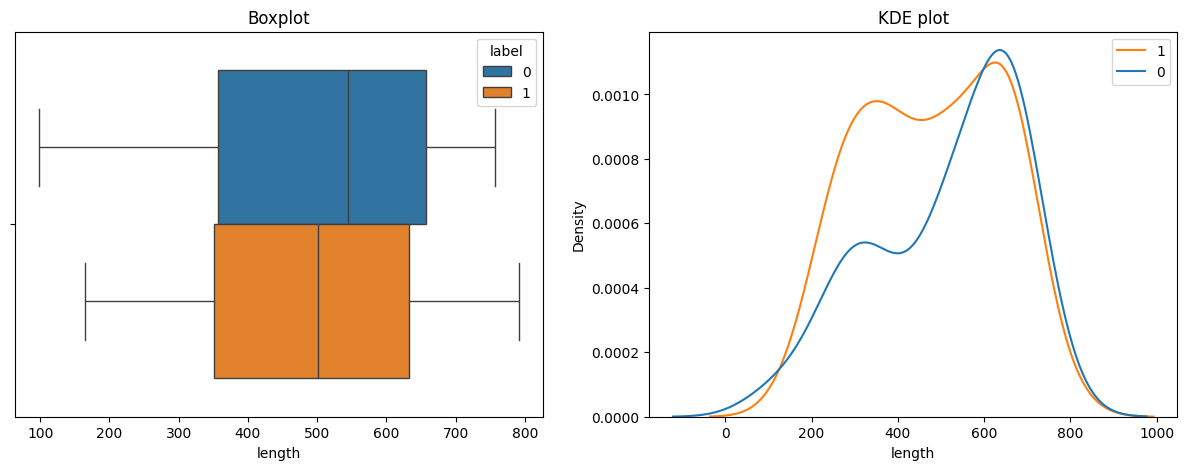

In [21]:
plot_feature(df_train, "length")

In [22]:
def with_word_count(df: pd.DataFrame) -> pd.DataFrame:
    def count_words(text: str) -> int:
        return len(text.split())

    df["word_count"] = df["text"].apply(count_words)
    return df

In [23]:
df_train = with_word_count(df_train)
df_test = with_word_count(df_test)
df_aug = with_word_count(df_aug)

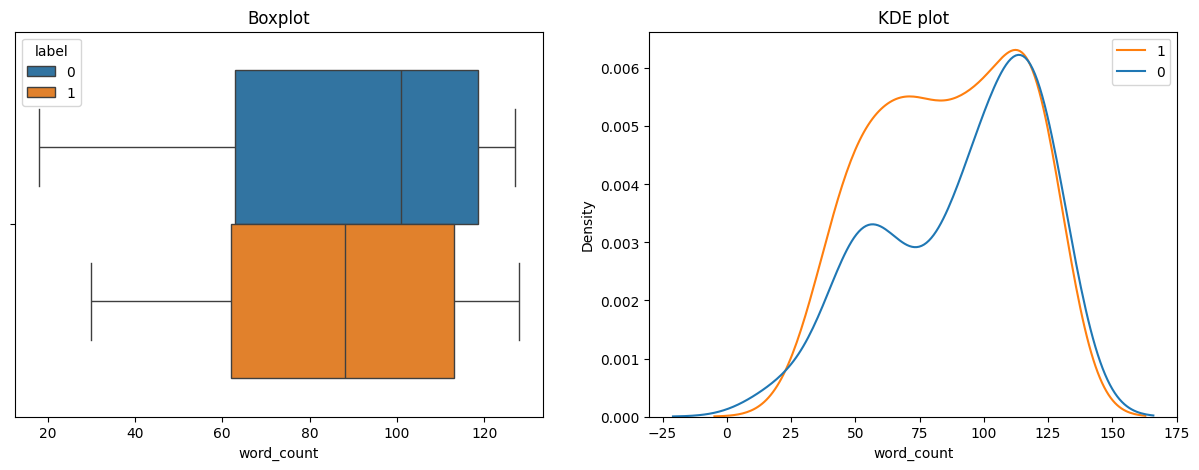

In [24]:
plot_feature(df_train, "word_count")

In [25]:
def with_avg_word_length(df: pd.DataFrame) -> pd.DataFrame:
    def avg_word_length(text: str) -> float:
        words = text.split()
        return sum(len(word) for word in words) / len(words)

    df["avg_word_length"] = df["text"].apply(avg_word_length)
    return df

In [26]:
df_train = with_avg_word_length(df_train)
df_test = with_avg_word_length(df_test)
df_aug = with_avg_word_length(df_aug)

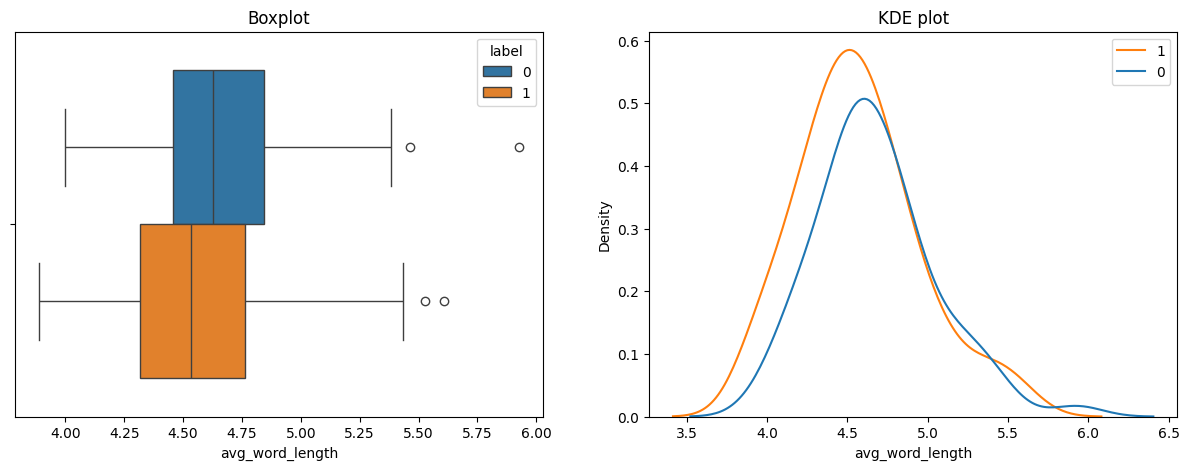

In [27]:
plot_feature(df_train, "avg_word_length")

In [28]:
def with_avg_sentence_length(df: pd.DataFrame) -> pd.DataFrame:
    def avg_sentence_length(text: str) -> float:
        sentences = tokenize.sent_tokenize(text)
        return sum(len(sentence) for sentence in sentences) / len(sentences)

    df["avg_sentence_length"] = df["text"].apply(avg_sentence_length)
    return df

In [29]:
df_train = with_avg_sentence_length(df_train)
df_test = with_avg_sentence_length(df_test)
df_aug = with_avg_sentence_length(df_aug)

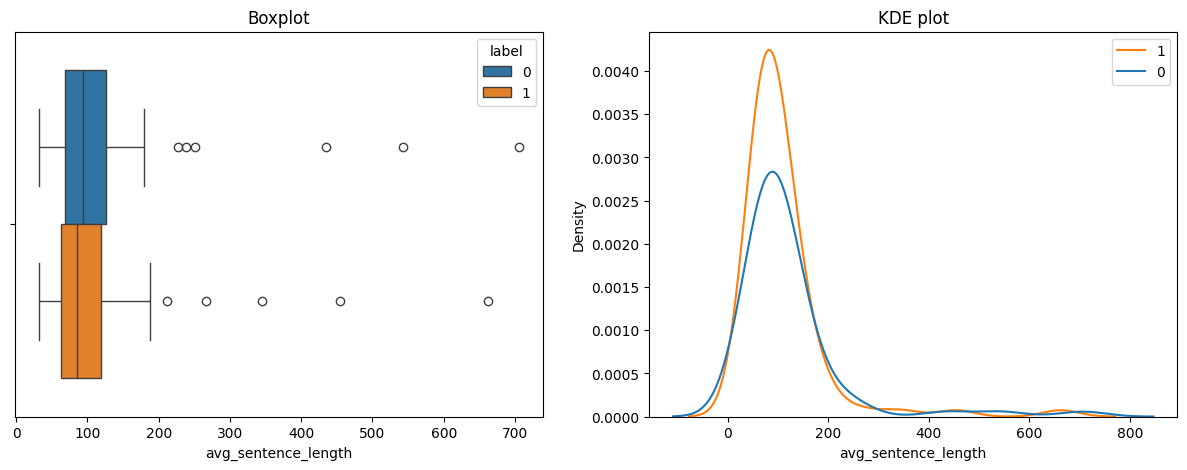

In [30]:
plot_feature(df_train, "avg_sentence_length")

In [31]:
def with_avg_sentence_word_count(df: pd.DataFrame) -> pd.DataFrame:
    def avg_sentence_word_count(text: str) -> float:
        sentences = tokenize.sent_tokenize(text)
        return sum(len(sentence.split()) for sentence in sentences) / len(sentences)

    df["avg_sentence_word_count"] = df["text"].apply(avg_sentence_word_count)
    return df

In [32]:
df_train = with_avg_sentence_word_count(df_train)
df_test = with_avg_sentence_word_count(df_test)
df_aug = with_avg_sentence_word_count(df_aug)

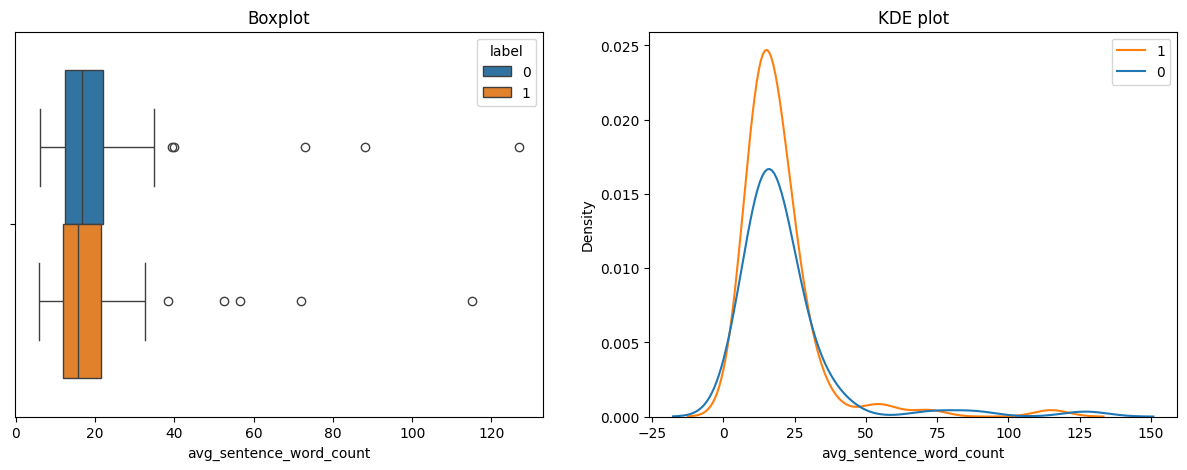

In [33]:
plot_feature(df_train, "avg_sentence_word_count")

In [34]:
print(f"Average Review Length:       {df_train['length'].mean():.2f}")
print(f"Average Word Count:          {df_train['word_count'].mean():.2f}")
print(f"Average Word Length:         {df_train['avg_word_length'].mean():.2f}")
print(f"Average Sentence Length:     {df_train['avg_sentence_length'].mean():.2f}")
print(f"Average Sentence Word Count: {df_train['avg_sentence_word_count'].mean():.2f}")

Average Review Length:       494.93
Average Word Count:          88.28
Average Word Length:         4.62
Average Sentence Length:     114.18
Average Sentence Word Count: 20.32


Now, let's dive deeper into the text data. Before doing that, we need to preprocess the text data by removing punctuation, converting all text to lowercase, and removing stopwords. We can also lemmatize the text data.

The difference between stemming and lemmatization is that lemmatization considers the context and converts the word to its meaningful base form, while stemming just removes the suffixes.

In [35]:
def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^a-z 0-9 ']", "", text)
    text = re.sub(r"\s+", " ", text)  # Remove extra spaces
    return text

In [36]:
def remove_stopwords(text: str, stopwords: set = set(stopwords.words("english"))) -> str:
    return " ".join([word for word in text.split() if word not in stopwords])

In [37]:
def lemmatize_text(text: str) -> str:
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

In [38]:
def preprocess_text(df: pd.DataFrame) -> pd.DataFrame:
    df["text"] = df["text"].apply(clean_text)
    df["text"] = df["text"].apply(remove_stopwords)
    df["text"] = df["text"].apply(lemmatize_text)
    return df

In [39]:
df_train = preprocess_text(df_train)
df_test = preprocess_text(df_test)
df_aug = preprocess_text(df_aug)

In [40]:
df_train.head(10)["text"]

0    fairly good romantic comedy think i've ever se...
1    dressed kill one best thriller ever made deali...
2    i'm glad user date liked movie coming forward ...
3    needed excuse get house paint dried left movie...
4    john candy's performance upon crime possibly b...
5    movie maybe really bad alot fun bad acting poo...
6    besides boring scene oppressive dark movie tri...
7    exactly sort saturday matinee serial loved wor...
8    slick prehays code still sassy would highly re...
9    like film lot wonderful chemistry actor tell s...
Name: text, dtype: object

In [41]:
df_aug.head(10)["text"]

0    relation fortier profiler fact police series v...
1    process trying establish audiences' empathy ja...
2    give movie 7 10 villain interesting role unkno...
3    best scifi seen 29 year watching scifi also be...
4    appalling piece rubbish people blubber good ye...
5    quite possibly francis veber one best comedy d...
6    film failed explore humanity animal left empty...
7    frailty810it's nonsensical title bill paxton d...
8    although remade several time movie classic see...
9    kid totally loved bill ted movie night bogus j...
Name: text, dtype: object

In [42]:
new_stopwords = {"i'm", "i've", "i'll"}

df_train["text"] = df_train["text"].apply(remove_stopwords, stopwords=new_stopwords)
df_test["text"] = df_test["text"].apply(remove_stopwords, stopwords=new_stopwords)
df_aug["text"] = df_aug["text"].apply(remove_stopwords, stopwords=new_stopwords)

In [43]:
df_train.head(10)["text"]

0    fairly good romantic comedy think ever seen me...
1    dressed kill one best thriller ever made deali...
2    glad user date liked movie coming forward unde...
3    needed excuse get house paint dried left movie...
4    john candy's performance upon crime possibly b...
5    movie maybe really bad alot fun bad acting poo...
6    besides boring scene oppressive dark movie tri...
7    exactly sort saturday matinee serial loved wor...
8    slick prehays code still sassy would highly re...
9    like film lot wonderful chemistry actor tell s...
Name: text, dtype: object

We can find the most common words in the reviews.

In [44]:
def get_most_common_words(df_train: pd.DataFrame, df_aug: pd.DataFrame, n: int = 20) -> list:
    words = " ".join(df_train["text"]).split()
    words += " ".join(df_aug["text"]).split()
    return Counter(words).most_common(n)

In [45]:
most_common_words = get_most_common_words(df_train, df_aug, 40)
most_common_words

[('movie', 1522),
 ('film', 934),
 ('one', 618),
 ('like', 450),
 ('good', 407),
 ('time', 309),
 ('story', 286),
 ('see', 281),
 ('bad', 261),
 ('make', 256),
 ('great', 250),
 ('even', 248),
 ('really', 241),
 ('character', 221),
 ('scene', 215),
 ('would', 214),
 ('watch', 211),
 ('get', 207),
 ('think', 206),
 ('acting', 204),
 ('people', 199),
 ('well', 196),
 ('seen', 195),
 ('made', 194),
 ('best', 186),
 ('much', 179),
 ('show', 173),
 ('plot', 172),
 ('way', 171),
 ('first', 169),
 ('ever', 168),
 ('love', 164),
 ('actor', 157),
 ('could', 149),
 ('also', 148),
 ('better', 144),
 ('thing', 144),
 ('go', 143),
 ('funny', 139),
 ('never', 137)]

Let's also remove some common words that are not stopwords but are not useful for sentiment analysis, such as "movie," "film," "actor," "actress," etc.

In [46]:
stopwords = {
    "movie", "film", "one", "time", "make",
    "even", "really", "character", "scene",
    "would", "get", "acting", "story", "actor",
    "actress", "plot", "people", "seen", "made",
    "show", "way", "ever", "could", "also", "thing", "go",
}

df_train["text"] = df_train["text"].apply(remove_stopwords, stopwords=stopwords)
df_test["text"] = df_test["text"].apply(remove_stopwords, stopwords=stopwords)
df_aug["text"] = df_aug["text"].apply(remove_stopwords, stopwords=stopwords)

In [47]:
most_common_words = get_most_common_words(df_train, df_aug, 20)
most_common_words

[('like', 450),
 ('good', 407),
 ('see', 281),
 ('bad', 261),
 ('great', 250),
 ('watch', 211),
 ('think', 206),
 ('well', 196),
 ('best', 186),
 ('much', 179),
 ('first', 169),
 ('love', 164),
 ('better', 144),
 ('funny', 139),
 ('never', 137),
 ('look', 132),
 ('performance', 130),
 ('know', 128),
 ('say', 122),
 ('many', 121)]

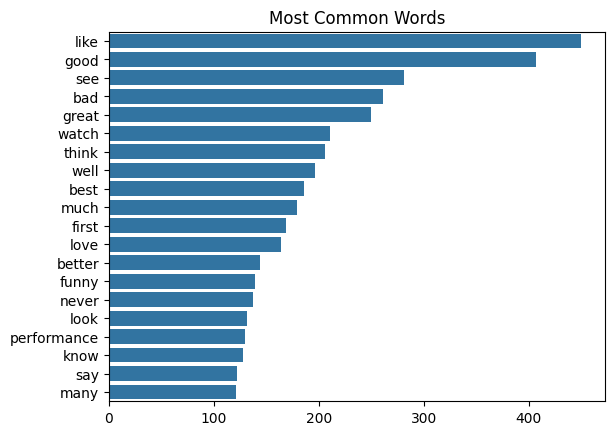

In [48]:
sns.barplot(x=[word[1] for word in most_common_words], y=[word[0] for word in most_common_words])
plt.title("Most Common Words")
plt.show()

Sometimes, using n-grams can help us understand the context of the text better. Let's use bigrams and trigrams to find the most common n-grams in the reviews.

In [49]:
def get_n_grams(df: pd.DataFrame, n: int = 2, top_n: int = 20) -> list:
    n_grams = []
    for text in df["text"]:
        text_n_grams = list(nltk.ngrams(text.split(), n))
        text_n_grams = [" ".join(n_gram) for n_gram in text_n_grams]
        n_grams += text_n_grams
    return Counter(n_grams).most_common(top_n)

In [50]:
train_bigrams = get_n_grams(df_train, n=2)
train_trigrams = get_n_grams(df_train, n=3)

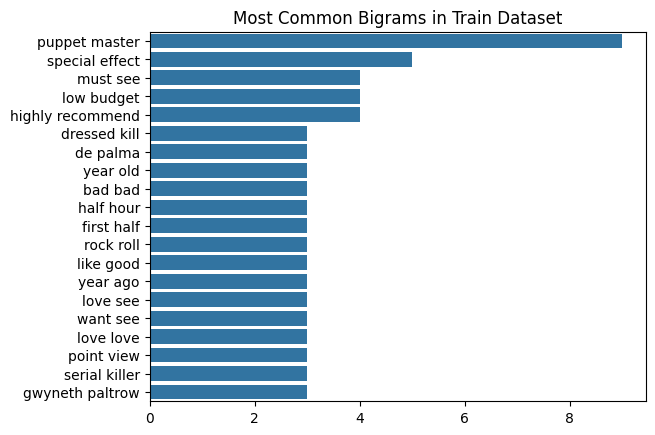

In [51]:
sns.barplot(x=[bigram[1] for bigram in train_bigrams], y=[bigram[0] for bigram in train_bigrams])
plt.title("Most Common Bigrams in Train Dataset")
plt.show()

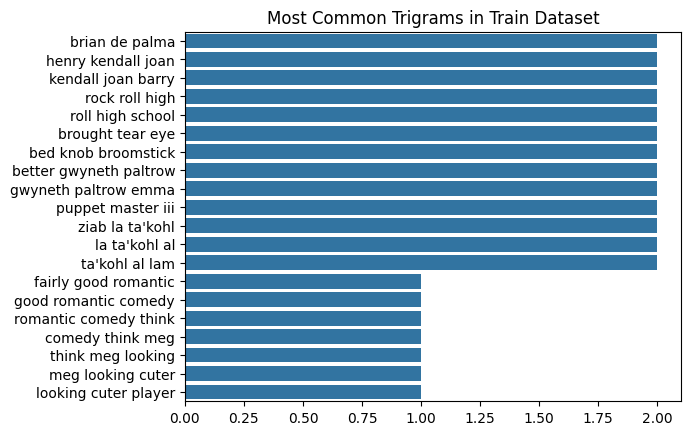

In [52]:
sns.barplot(x=[trigram[1] for trigram in train_trigrams], y=[trigram[0] for trigram in train_trigrams])
plt.title("Most Common Trigrams in Train Dataset")
plt.show()

In [53]:
aug_bigrams = get_n_grams(df_aug, n=2)
aug_trigrams = get_n_grams(df_aug, n=3)

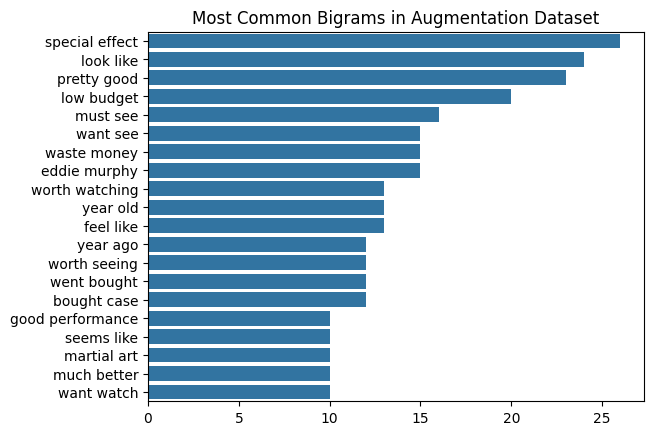

In [54]:
sns.barplot(x=[bigram[1] for bigram in aug_bigrams], y=[bigram[0] for bigram in aug_bigrams])
plt.title("Most Common Bigrams in Augmentation Dataset")
plt.show()

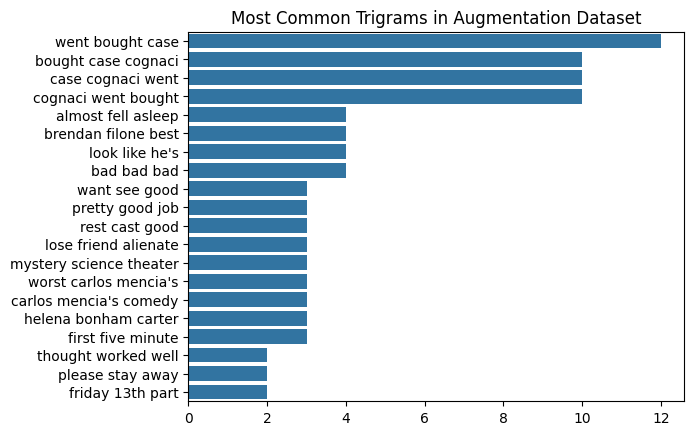

In [55]:
sns.barplot(x=[trigram[1] for trigram in aug_trigrams], y=[trigram[0] for trigram in aug_trigrams])
plt.title("Most Common Trigrams in Augmentation Dataset")
plt.show()

Let's generate a wonderful word cloud to visualize the most common words in the reviews =)

In [56]:
def plot_wordcloud(df: pd.DataFrame, mask_path: str) -> None:
    mask = np.array(Image.open(mask_path))
    wc = WordCloud(
        background_color="white",
        mask=mask,
        contour_width=2,
        contour_color="black",
        max_words=200,
    ).generate(" ".join(df["text"]))

    plt.figure(figsize=(10, 10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

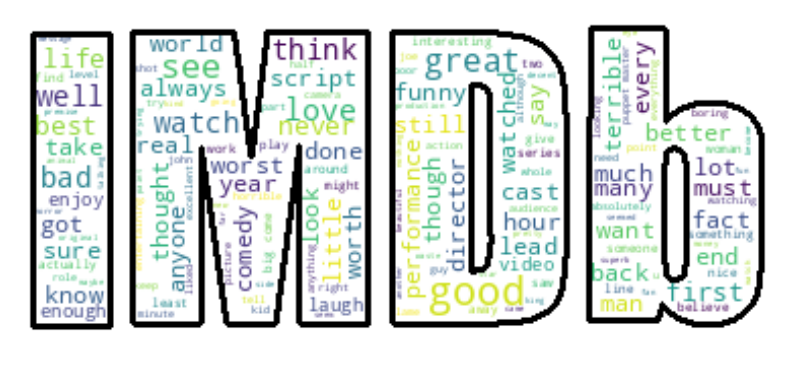

In [57]:
plot_wordcloud(df_train, IMDB_LOGO_PATH)

## Feature Engineering

We'll explore methods for extracting features from text data and provide a brief explanation of each. The TAs have already added these embedding features to each sentence in the dataset to simplify the complexity of NLP tasks, allowing us to focus on other aspects of our work. It's up to us how we want to use these features along the way.

In [58]:
# code

## Semi Supervised

We have learned that supervised learning involves training a model on a labeled dataset, where each example is paired with an output label, while unsupervised learning deals with unlabeled data and aims to find hidden patterns or structures. Semi-supervised learning is a hybrid approach that combines both methods. It uses a small amount of labeled data along with a large amount of unlabeled data to improve learning accuracy. This approach leverages the labeled data to guide the learning process and the unlabeled data to capture the underlying data distribution, making it particularly useful when labeling data is expensive or time-consuming.

### Traditional Methods (Label Propagation)

We should research label propagation techniques and their traditional methods. We'll utilize one of these methods, such as KMeans, to propagate labels for unlabeled data. Next, we will train a model using the extracted features and propagate labels as desired (whether using only hand-labeled data or a combination of labeled and propagated labels is up to us).

In [59]:
# code

### LLMs

For working with LLMs, the TAs suggest us look at the [documentation](https://huggingface.co/docs) on the Hugging Face website. Hugging Face is a leading platform for natural language processing, offering high-level libraries like [Transformers](https://huggingface.co/docs/transformers/index). The Transformers library provides pre-trained models and tools that simplify implementing and fine-tuning state-of-the-art language models for various NLP tasks, such as text classification, translation, and question-answering. This library makes it easy to leverage powerful models without needing deep expertise in machine learning, accelerating your development process. For more information, they suggest us check [this](https://huggingface.co/docs/transformers/llm_tutorial) tutorial on how to use LLMs.

Now, let's integrate an LLM (Large Language Model) for label generation. We should research how an LLM can be applied to a specific task like classification and explain the circumstances under which each method should be used.

We should also beware that using an LLM can be time consuming, so need to save our results. Just like the previous step, we'll train a model using the extracted features and new labeled dataset (we can even use the LLM as your classifier!).

For this task, we are going to use prompt engineering methods to generate labels with the [Phi-3](https://huggingface.co/microsoft/Phi-3-mini-128k-instruct) model. The TAs have already implemented a function to load the model for us, so we don't need to worry about that.

In [60]:
# code

### Evaluation

We'll evaluate both models on the test set and compare their results. For evaluation metrics, we can use the ones we have learned in class. To find the best model in each method, we'll need to explore different methods for labeling, models, datasets, features (including text features), and more.

In [61]:
# code

## Questions

1. **Research semi-supervised problems and explain how to select a proportion of data for manual labeling. Does the choice of data matter?**

2. **For label propagation, how many data points did you label using your manually labeled data? Explain the trade-off between quality and quantity of your labeled data.**

3. **Research the limitations of label propagation methods. Can these limitations be overcome using a large language model (LLM)? If yes, explain how and why using LLMs is more effective for these tasks.**

4. **Research the history of language modeling, their evolution, and explain how they work. Discuss the advantages and limitations of language models, especially large language models (LLMs), in various tasks.**

5. **For each method (LLM/Label-Propagation), explain its advantages and disadvantages.**

6. **Certainly, you have worked with large language models (LLMs) since they were made public, and you might even be using one right now to help you with your assignment! How has your experience been while interacting with one of them? How do other LLMs differ from each other? Name some of these LLMs that you have worked with and share your opinion about them.**

## References

- [Hugging Face](https://huggingface.co/docs)
- [Transformers](https://huggingface.co/docs/transformers/index)
- [LLMs](https://huggingface.co/docs/transformers/llm_tutorial)
- [Phi-3](https://huggingface.co/microsoft/Phi-3-mini-128k-instruct)
- [EDA on Text Data](https://www.kaggle.com/code/harshsingh2209/complete-guide-to-eda-on-text-data)
- [Word Cloud](https://www.datacamp.com/tutorial/wordcloud-python)